Vamos a usar las implementaciones de Nearest Neighbours de la librería Sklearn, con todas las opciones por defecto salvo las que se discutan en cada punto. Como siempre, hay que implementar código que nos permita seleccionar el k óptimo sobre un conjunto de validación, nos devuelva el clasificador o regresor entrenado, y nos permita hacer curvas de entrenamiento, validación y test en función del número de vecinos.

In [1]:
from base import *
from math import inf
from copy import deepcopy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


In [2]:
def medir_error(df: pd.DataFrame, df_entrenado: pd.DataFrame, red):
  # if is_classifier(red):
  #   return sk.metrics.zero_one_loss(df, df_entrenado)
  # else:
  #   return sk.metrics.mean_squared_error(df, df_entrenado)
  return 1 - accuracy_score(df, df_entrenado)

def neighbor(k):
  return KNeighborsClassifier(n_neighbors=k, weights='uniform')

def entrenar(problema, k_values, X_train, y_train, X_val, y_val, X_test, y_test):
  error_train_data = []
  error_val_data = []
  error_test_data = []

  best_error_val = inf

  for k in k_values:
    knn = neighbor(k)
    knn.fit(X_train, y_train)

    train_entrenado = knn.predict(X_train)
    val_entrenado = knn.predict(X_val)
    test_entrenado = knn.predict(X_test)

    current_error_train = medir_error(y_train, train_entrenado, knn)
    current_error_val = medir_error(y_val, val_entrenado, knn)
    current_error_test = medir_error(y_test, test_entrenado, knn)

    error_train_data.append(current_error_train)
    error_val_data.append(current_error_val)
    error_test_data.append(current_error_test)

    if current_error_val < best_error_val:
      best_error_val = current_error_val
      best_k = k
      best_knn = deepcopy(knn)

  return best_k, best_knn, error_train_data, error_val_data, error_test_data

In [3]:
def graph_errores(error_df: pd.DataFrame, referencia):
  fig, ax = plt.subplots(figsize=(15, 10))
  clases = pd.unique(error_df['Clase'])

  for c in clases:
    df = error_df[error_df['Clase'] == c]
    df = df.groupby(referencia).mean().reset_index()
    
    plt.plot(df[referencia], df['Error'], linestyle='-')

  ax.grid(which='both', color='grey', linewidth=1, linestyle='-', alpha=0.2)

  plt.legend(clases, ncol = 4)
  plt.xlabel(referencia, size=14, labelpad=20)
  plt.ylabel('Error', size=14, labelpad=20)

a) 
- Resuelva el problema de las espirales-anidadas usando k-nn. Utilice el datasets de "espirales con ruido" de esta página. Hay una versión "original" y otra que tiene agregadas dos variables que contienen ruido uniforme. 
- Realice gráficas de las predicciones sobre el conjunto de test, y gráficas de errores vs número de vecinos. 
- Compare el resultado con el obtenido con árboles de decisión, los dos métodos sobre las dos versiones del dataset.

In [4]:
def ej1a_dfs(filename, con_ruido):
  if con_ruido == True:
    names = [0, 1, 2, 3, 'Clase']
    dos_e_dfs = GeneradorDFCSV(filename, custom=True, names=names)
    print("Con ruido")
  else:
    names = [0, 1, "Clase"]
    dos_e_dfs = GeneradorDFCSV(filename)

  df_train_val = dos_e_dfs.df_data #.sample(frac=0.5)
  X_train_val, y_train_val = df_train_val[names[:-1]], df_train_val['Clase']
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

  df_test = dos_e_dfs.df_test
  X_test, y_test = df_test[names[:-1]], df_test['Clase']

  return X_train, y_train, X_test, y_test, X_val, y_val, df_test

In [5]:
def ej1(filename, con_ruido=False):
  X_train, y_train, X_test, y_test, X_val, y_val, df_test = ej1a_dfs(filename, con_ruido)
  k_values = range(1, 31)
  best_k, best_knn, error_train_data, error_val_data, error_test_data = entrenar('knclasif', k_values, X_train, y_train, X_val, y_val, X_test, y_test)

  errores = []
  for i in k_values:
    errores.append([error_train_data[i-1], i, "Error train"])
    errores.append([error_val_data[i-1], i, "Error validación"])
    errores.append([error_test_data[i-1], i, "Error test"])
  
  knn_pred = best_knn.predict(X_test)

  clf = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.005,random_state=0,min_samples_leaf=5)
  clf.fit(X_train, y_train)
  arbol_predict = clf.predict(X_test)

  frame = {0 : X_test[0], 1 : X_test[1], 'Clase' : knn_pred}
  df_knn = pd.DataFrame(frame, columns=[0, 1, 'Clase'])

  arbol_frame = {0 : X_test[0], 1 : X_test[1], 'Clase' : arbol_predict}
  df_arbol = pd.DataFrame(arbol_frame, columns=[0, 1, 'Clase'])

  GraficadorDF(df_test).graph_puntos('Set de test original')
  GraficadorDF(df_knn).graph_puntos(f'KNN entrenado con #{best_k} vecinos')
  GraficadorDF(df_arbol).graph_puntos('Arbol de decisión')

  errores_df = pd.DataFrame(errores, columns=['Error', 'k', 'Clase'])
  graph_errores(errores_df, 'k')
  #return errores_df

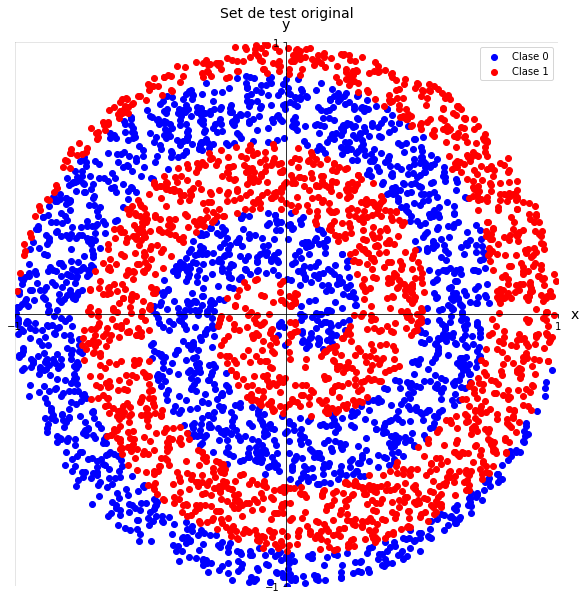

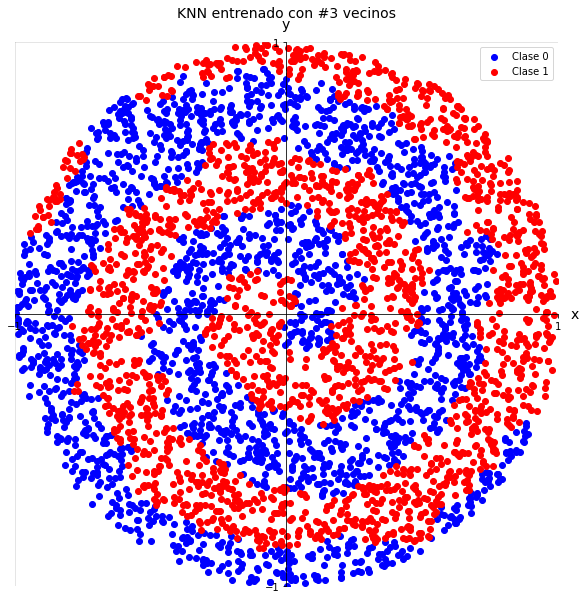

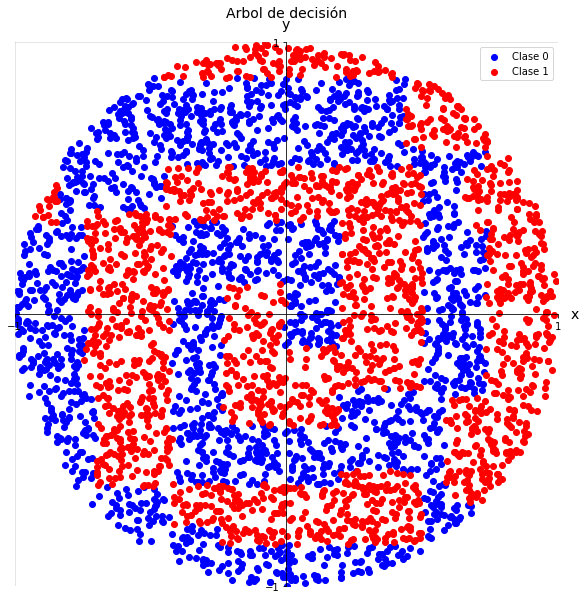

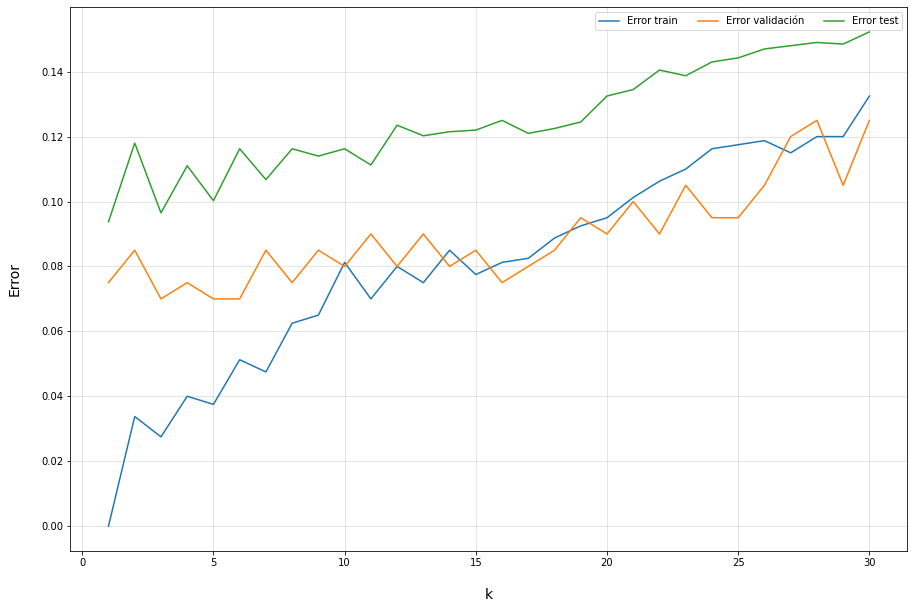

In [6]:
ej1('tp4/c_0')

Para la clasificación de datos sin ruido, se puede ver que el KNN dibuja mucho mejor el espiral comparado con el árbol de decisión. Acorde a esto, los errores parecen ser bastante chicos.  

Con ruido


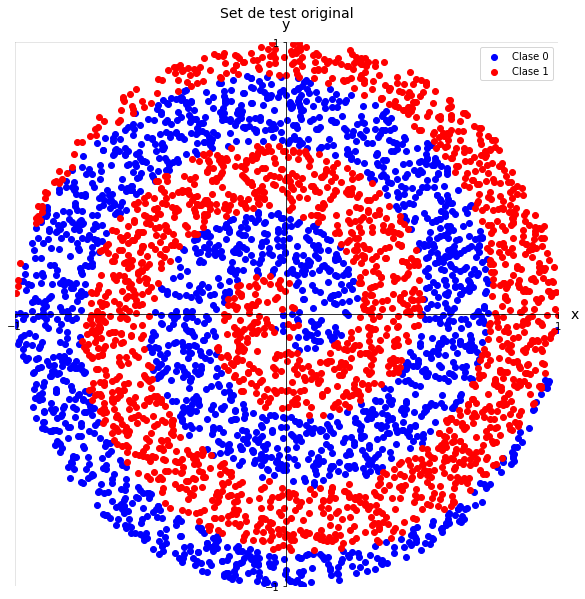

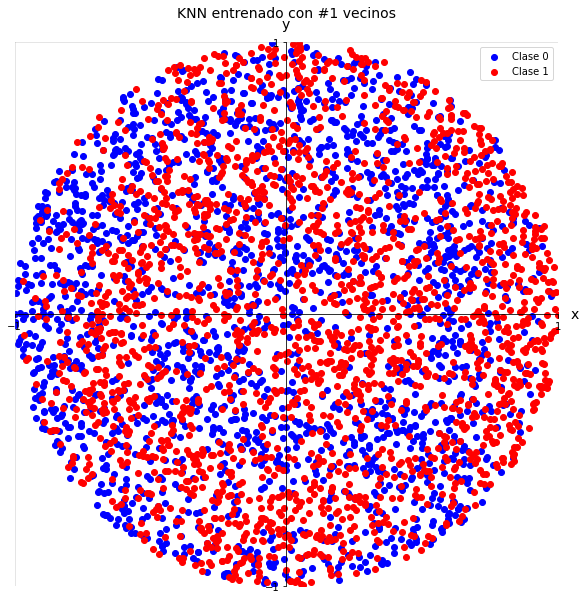

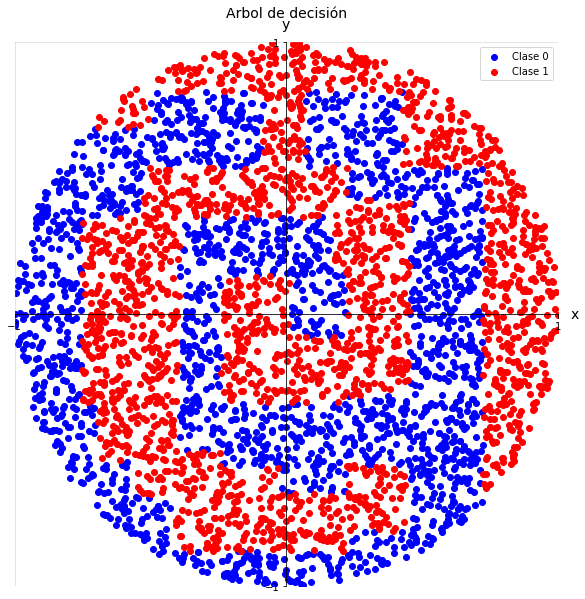

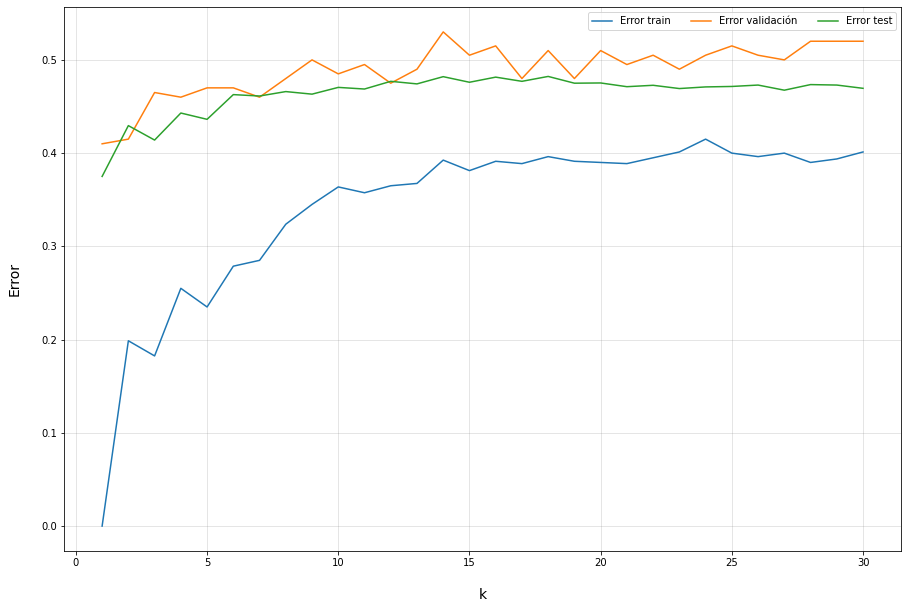

In [7]:
ej1('tp4/c_2', con_ruido=True)

Para los datos con ruido, se puede notar que el clasificador falla notablemente; no pudo siquiera dibujar alguna curva correctamente. Como se vio en la teoría, la introducción de ruido en el dataset afecta sensiblemente al clasificador si "opaca" a los datos útiles. En este caso, tenemos dos datos útiles y dos inútiles y esto hace que el peso obtenido ofusque la toma de decisión fácilmente.